In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU.")

CUDA is available! Using GPU.


In [4]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(nn.Module):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model
model = inceptionresnetv2(num_classes=1000, pretrained='imagenet')
    

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:28<00:00, 356kB/s]


In [5]:
model.last_linear = nn.Linear(1536,512)
nn.init.xavier_uniform_(model.last_linear.weight)
nn.init.constant_(model.last_linear.bias, 0)
for param in model.parameters():
    param.requires_grad = False
for param in model.last_linear.parameters():
    param.requires_grad = True
def list_parameters(model):
    print("Parameter List:")
    for name, param in model.named_parameters():
        print(f"Name: {name}, Requires Grad: {param.requires_grad}")
list_parameters(model)


Parameter List:
Name: conv2d_1a.conv.weight, Requires Grad: False
Name: conv2d_1a.bn.weight, Requires Grad: False
Name: conv2d_1a.bn.bias, Requires Grad: False
Name: conv2d_2a.conv.weight, Requires Grad: False
Name: conv2d_2a.bn.weight, Requires Grad: False
Name: conv2d_2a.bn.bias, Requires Grad: False
Name: conv2d_2b.conv.weight, Requires Grad: False
Name: conv2d_2b.bn.weight, Requires Grad: False
Name: conv2d_2b.bn.bias, Requires Grad: False
Name: conv2d_3b.conv.weight, Requires Grad: False
Name: conv2d_3b.bn.weight, Requires Grad: False
Name: conv2d_3b.bn.bias, Requires Grad: False
Name: conv2d_4a.conv.weight, Requires Grad: False
Name: conv2d_4a.bn.weight, Requires Grad: False
Name: conv2d_4a.bn.bias, Requires Grad: False
Name: mixed_5b.branch0.conv.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.bias, Requires Grad: False
Name: mixed_5b.branch1.0.conv.weight, Requires Grad: False
Name: mixed_5b.branch1.0.bn.weight, Requ

## Dataloader

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset
from torch import nn, Tensor
# df = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')
# captions = df['caption']
# train_iter = iter(captions)

# tokenizer = get_tokenizer('basic_english')
# vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
# vocab.set_default_index(vocab['<unk>'])
# print(vocab)

# def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
#     """Converts raw text into a flat Tensor."""
#     data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
#     return data

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset

df = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')
captions = df['caption']
train_iter = iter(captions)

tokenizer = get_tokenizer('basic_english')

# Define the vocabulary with the special token '<pad>'
specials = ['<unk>', '<pad>','<start>','<eos>']
vocab = build_vocab_from_iterator(map(tokenizer, train_iter),min_freq=1, specials=specials)
vocab.set_default_index(vocab['<unk>'])
max_len = max(len(tokenizer(item)) for item in captions)
max_len = max(max_len,512)
print(max_len)
def data_process(raw_text_iter, vocab):
    """Converts raw text into a flat Tensor."""
    data = []
    for item in raw_text_iter:
        tokens = [vocab[token] for token in tokenizer(item)]
        # Pad the tokens to ensure uniform length
        padded_tokens = tokens + [vocab['<pad>']] * (max_len - len(tokens))
        padded_tokens = padded_tokens[:51]
        caption_length = 50
        clipped_caption = torch.as_tensor(padded_tokens[:caption_length])
        #clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
        one_hot_tensor = torch.zeros(50, len(vocab))
        one_hot_tensor[torch.arange(50), clipped_caption] = 1
        data.append((one_hot_tensor, torch.tensor(padded_tokens, dtype=torch.long)))
    return data

# Calculate the maximum length of tokens in the dataset



# print(vocab)
# print(processed_data)


512


In [7]:
train_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')['caption']
train_iter = iter(train_captions)
test_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv')['caption']
test_iter = iter(test_captions)
val_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv')['caption']
val_iter = iter(val_captions)
train_data = data_process(train_iter,vocab)
val_data = data_process(val_iter,vocab)
test_data = data_process(test_iter,vocab)
print(test_data[0])
#print(train_data)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]), tensor([  6,  35,  50,  16, 859,   8,   4, 157,  13,  29,  10,  20,   5,  12,
          7,  41, 116,  13,  29,  10,   4,  50,   5,  12,   7,   6,  59,  13,
         29,  10,   4,  50,  16, 109, 162,   8,  20,   5,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1]))


In [8]:
# class CustomDataset(Dataset):
#     def __init__(self, image_folder, csv_file, transform=None):
#         self.image_folder = image_folder
#         self.data = pd.read_csv(csv_file)
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
#         image = Image.open(img_name).convert("RGB")
#         caption = self.data.iloc[idx, 2]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, caption
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, image_folder, captions, csv_file, transform=None):
        self.image_folder = image_folder
        self.captions = captions
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB")
        caption = self.captions[idx]
        #print("Dataloader: caption:",caption)
        if self.transform:
            image = self.transform(image)
        
        return image, caption


# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms

# class CustomDataset(Dataset):
#     def __init__(self, image_folder, csv_file, transform=None, max_caption_length=1500):
#         self.image_folder = image_folder
#         self.data = pd.read_csv(csv_file)
#         self.transform = transform
#         self.max_caption_length = max_caption_length
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
#         image = Image.open(img_name).convert("RGB")
#         caption = self.data.iloc[idx, 2]
#         words = caption.split()
#         words = [word if word != '.' else '<SEP>' for word in words]
#         for i in range(len(words) - 1):
#             if words[i] == '<SEP>' and words[i + 1] != '<SEP>':
#                 words.insert(i + 1, '<EOS>')
#         if words[-1] != '<EOS>':
#             words.append('<EOS>')
#         words = words[:self.max_caption_length]
#         words += ['<PAD>'] * (self.max_caption_length - len(words))
        
#         caption = words
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, caption


In [9]:
import os
from PIL import Image
import pandas as pd

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv'
# train_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv'
# test_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv'
# validation_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# batch_size = 4
# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv'
train_dataset = CustomDataset(image_folder, train_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv'
test_dataset = CustomDataset(image_folder, test_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv'
validation_dataset = CustomDataset(image_folder, val_data, csv_file, transform=transform)

batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


Sample 1:


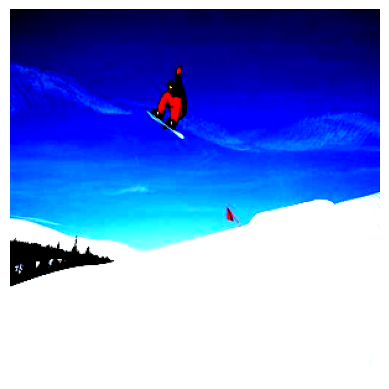

a man jumps in the air on his snowboard . the snow on the ground is neatly done . there is a red flag on the ground . the man is wearing red pants . there are trees off to the sides . there are some clouds in the sky .


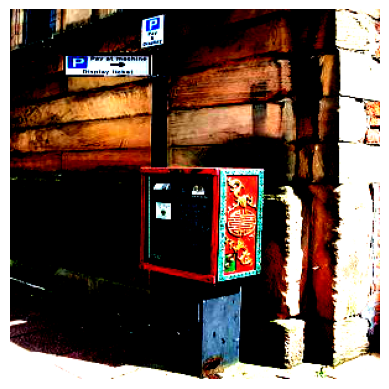

a black pole is standing beside an old parking meter . attached to the pole are parking signs . the meter machine is green with orange border at front . on the side is a drawing of dragon with abstract circle at the center . the border is green . the


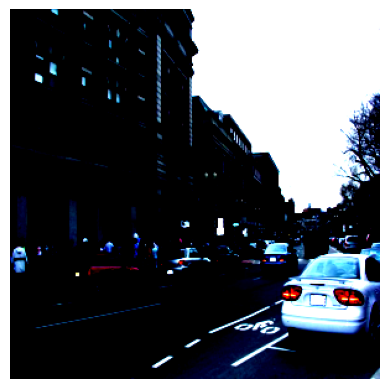

a book store on a busy but old fashioned city street has a long line , and a large crowd standing outside at dusk . cars are parked on both sides of the street , as cars are also driving down the street . the cars have their lights on ,


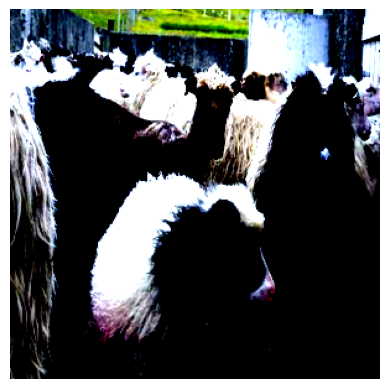

there is a group of sheep in an enclosure . the sheep have long wool coats . the sheep in the front is black and white with a pink nose . there is a sheep on the right with a black face and a red tag with black lettering . there


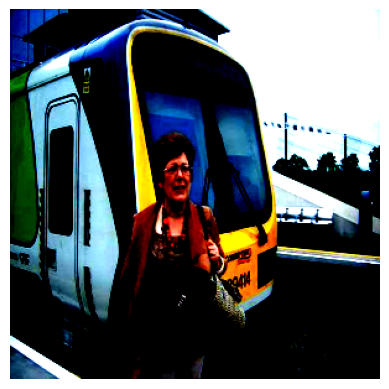

a woman is standing in front of the train . the woman is wearing glasses . the front of the train is yellow . the rest of the train is blue white and green . the woman is wearing two necklaces on her neck . the shorter necklace is orange and


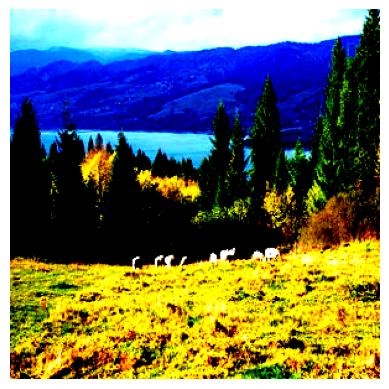

the image is of the field with pine trees . in the field , there are white sheep grazing . behind the pine trees is a calm , blue lake . beyond the lake are hills covered with green trees . the sky is cloudy and gloomy .


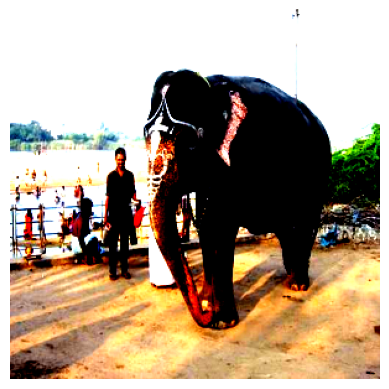

a man stands by an elephant . they are in a dirt area , but it is not a rural setting . in the background , there is a light pole , a fence , and a body of water that people are wading in . the elephant has designs painted


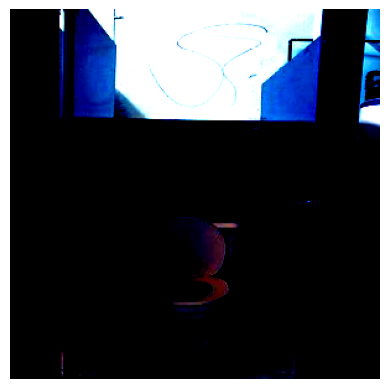

the image is of a public toilet . the stall walls and doors are a deep blue . the toilet bowl itself is white . the lid on the toilet is propped up . the tile floor around the toilet appears to be extremely dirty . there is a marker drawing


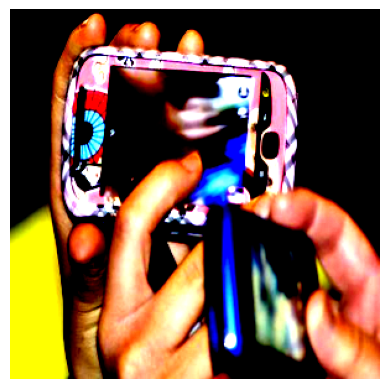

there is a person holding a cell phone . the cell phone is pink and has a case on it . the person is touching the screen of the cell phone . there is another phone in front of that one .


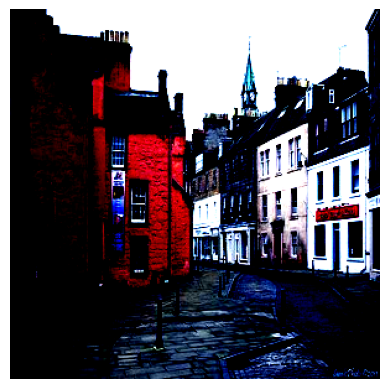

a colorful village is depicted in this picture . a sidewalk made of different shapes of concrete run on either side of the paved road . buildings several stories high line the sidewalks . the buildings are red , white , tan and black . in the distance a steeple with


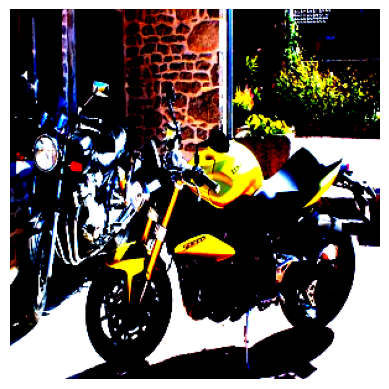

this picture is taken on a sunny day . two motorcycles are parked beside each other outside of a building . one of the motorcycles is black and yellow . the other motorcycle is black and silver . the building is made of different size stones . some plants and shrubs


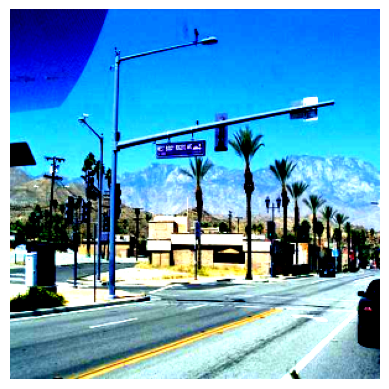

a silver light pole is above the road . there is a black car on the street . there is a brown building next to the street . there are tall palm trees on the sidewalk next to the street .


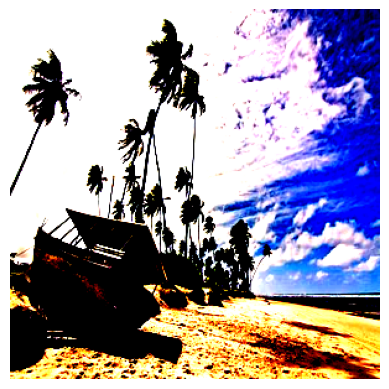

an old beat up and abandoned boat is on it ' s side on the sandy beach . there bottom of the boat is beige and crusty looking . the boat has a wooden canopy over the top suspended from five thin poles . there are foot prints in the sand


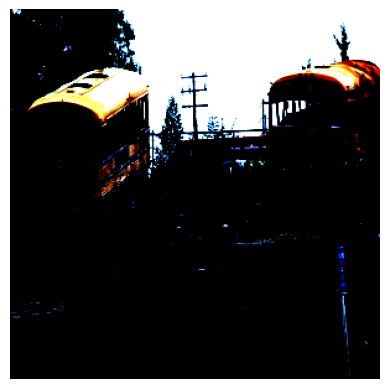

two old yellow school buses sit on flat and missing tires in a junkyard . the fronts of both buses are completely smashed in . a silver chain link fence surrounds the yard/ there are patches of grass and weeds growing in the cracks of the pavement . a blue handicap


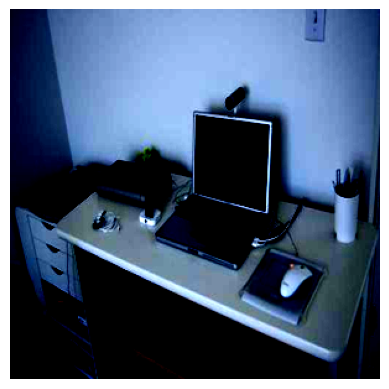

a white desk is against a white wall . on the desk is a white cup with writing pens in it , a computer monitor withe a wed camera attached to the top and keyboard . also a white computer mouse on a grey mouse pad . next to the monitor


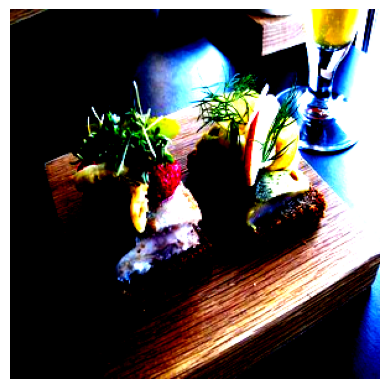

the picture was taken inside in a room with a black table . on the table are wood blocks . the wood blocks have food on it . the food is brown bread with meat on top . there are also garnishes on the food . the wood block is thick


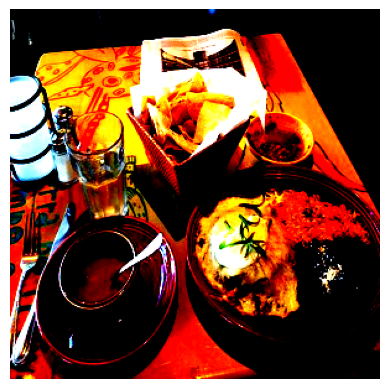

this is a lovely looking meal at a mexican restaurant . the tablecloth is yellow , orange and green . a tomato based soup is served , and there ' s a basket of tortilla chips alongside a small bowl of fresh salsa . the main meal appears to be chilis


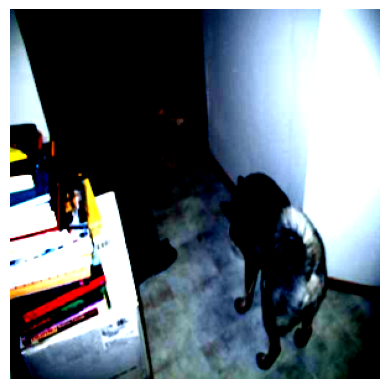

two dogs are seen together . one of the dogs is a grayish and white color and the other is black and brown . one dog is laying down and the other dog is looking towards the other .


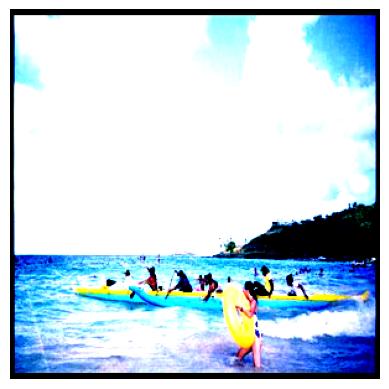

six people are inside a canoe . the canoe has a blue bottom and a yellow top . six people are rowing this canoe in the water . another woman , not inside the canoe is wading out in the water with a yellow inner tube . in the background ,


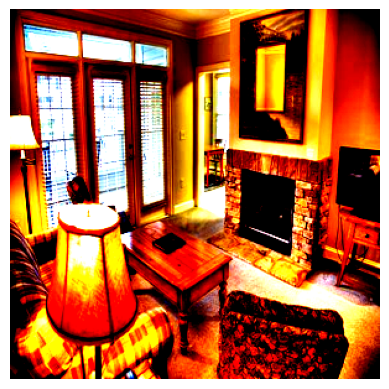

this is the living room there is a fireplace made of brick with a lamp next to a couch and a table . the colors are brown and the area is very clean . a tv that is black is sitting on a wooden stand next to another chair .


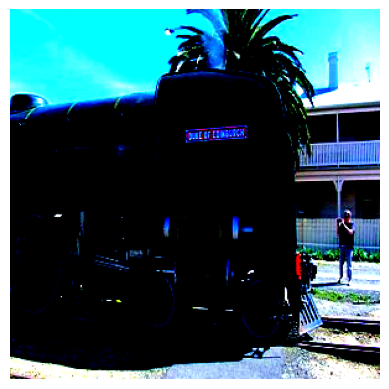

this photo is taken outside on a sunny day . a woman is standing in front of a white building holding a camera in her hands . the woman is wearing a dark shirt and gray pants . she is recording a large green train . the train is sitting parked


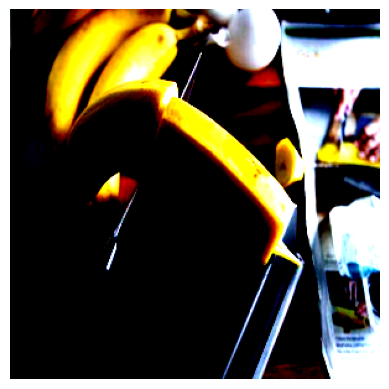

there are several bananas on a table . one is being cut i half by a black and silver knife . there is a newspaper on the table next to the bananas .


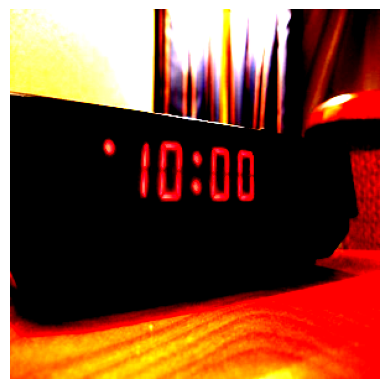

a black alarm clock is sitting on a wood table . there are striped curtains on the wall behind the table . the clock has red numbers on it . there is gold writing on the clock .


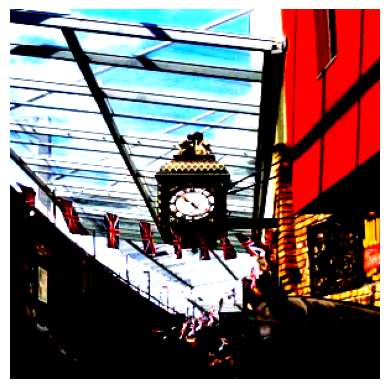

a glass roof runs over a pathway between two brick buildings . the area has been turned into an outdoor market , with various retail goods on display . a sculpture of a horse is in the foreground . union jack flags are hanging from ropes above the path . a


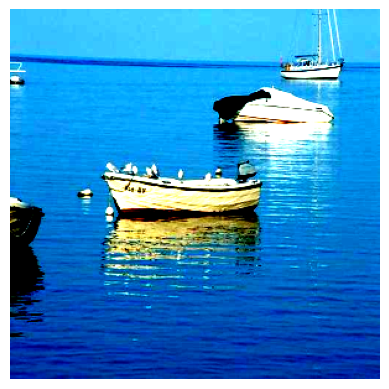

three boats are seen clearly in the bay . they appear to be stationary . two of the boats seem to be empty but the third boat in the distance has people on it . none of the boats have their sails up .


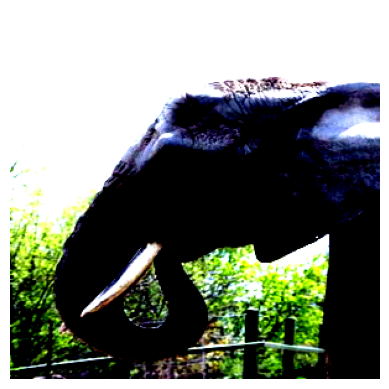

an adult male elephant is putting his trunk into his mouth , perhaps to feed . the elephant has a large white ivory tusk . his forehead and trunk have many wrinkles . he is gray . a gray fence with wires is in the background . behind the fence are


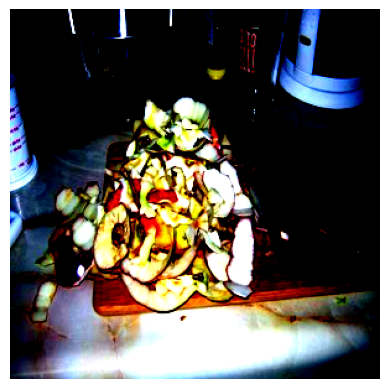

there is a wood cutting board on the white counter top . there is a metal bowl on the counter behind the board . there is a black knife on the board . there is a pile of food cut up on the board .


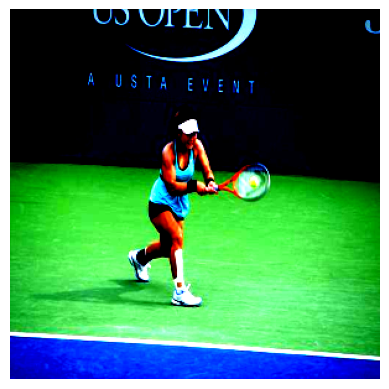

a professional woman tennis player is moving to her left about three feet behind the baseline and is stroking the ball with a two handed back stroke . she is a black pair of short and a turquoise tank shirt with the shirt tail out and almost covering the shorts .


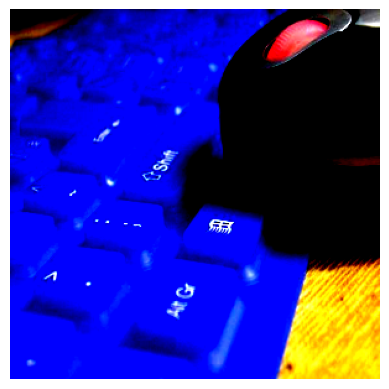

there is a blue keyboard on the desk . the desk is wooden and brown . the keyboard is plastic . there is a black keyboard mouse on top of the keyboard .


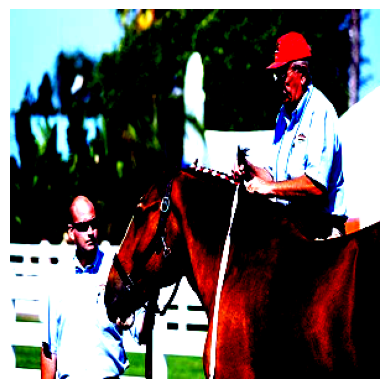

a man is braiding a red and white ribbon into the mane of a brown horse . the man is wearing glasses , a red hat , blue button down shirt , tan pants and a belt . the man has grey hair and a grey mustache . the horse is


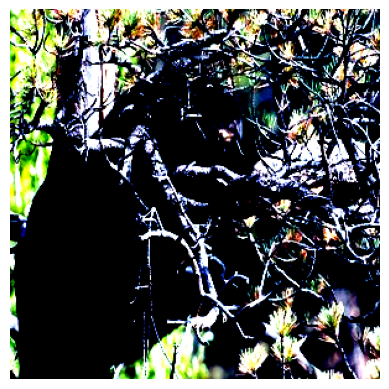

a large black bear is on a branch in a tree . the pine tree is mostly bare except for a few patches of needles spread out over the twigs and branches . there is sun shining on the tree , and on patches of the fur of the bear .


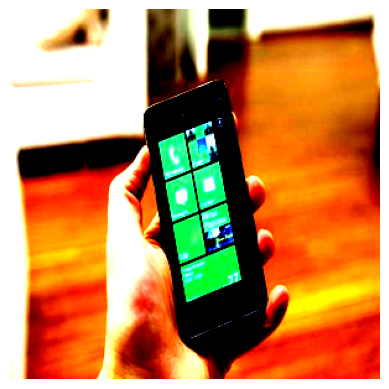

a person is holding a cell phone . the quality is very neat and crisp . they are holding a htc phone that is on one of the main screens . there is a wood floor and white couch .



In [10]:
import matplotlib.pyplot as plt
import numpy as np
def generate_text_from_tensor(tensor, vocab):
    """Converts a tensor back into text."""
    # Iterate over each token in the tensor
    tokens = [vocab.lookup_token(token) for token in tensor]
    # Remove '<pad>' tokens and '<eos>' tokens (if any)
    tokens = [token for token in tokens if token != '<pad>' and token != '<eos>']
    # Concatenate the tokens into a single string
    text = ' '.join(tokens)
    return text
num_samples = 1
for i, (images, captions) in enumerate(train_data_loader):
    if i >= num_samples:
        break
    #print(captions[1])
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions[1]):
        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        print(generate_text_from_tensor(caption,vocab))
    print()

# for i, (images, captions) in enumerate(test_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
#         # Display the image
#         plt.imshow(image_np)
#         plt.axis('off')
#         plt.show()
#         print(generate_text_from_tensor(caption,vocab))
#     print()
    
# for i, (images, captions) in enumerate(validation_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
#         # Display the image
#         plt.imshow(image_np)
#         plt.axis('off')
#         plt.show()
#         print(generate_text_from_tensor(caption,vocab))
#     print()


In [11]:
# num_samples = 1
# model.eval()
# # Iterate over the data loader and print random samples
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Prepare the input image
#         image = image.unsqueeze(0)  # Add batch dimension
#         # Forward pass
#         with torch.no_grad():
#             output = model(image)
        
#         # Print the output (or use it according to your requirement)
#         print("Output:", output)
#     print()

## Transformer Model

In [12]:
# import torch
# import torch.nn as nn

# # Create a Transformer model
# transformer_model = nn.Transformer(
#     d_model=512,  # Dimension of the model
#     nhead=8,      # Number of attention heads
#     num_encoder_layers=6,  # Number of encoder layers
#     num_decoder_layers=6,  # Number of decoder layers
#     dim_feedforward=2048,  # Dimension of the feedforward network
#     dropout=0.1,   # Dropout probability
#     activation='relu'  # Activation function ('relu' or 'gelu')
# )


In [13]:
import torch.nn.init as init
class my_transformer(nn.Module):
    def __init__(self,n_tokens):
        super(my_transformer, self).__init__()
#         self.transformer = nn.Transformer(
#                                 d_model=512,  # Dimension of the model
#                                 nhead=8,      # Number of attention heads
#                                 num_encoder_layers=6,  # Number of encoder layers
#                                 num_decoder_layers=6,  # Number of decoder layers
#                                 dim_feedforward=2048,  # Dimension of the feedforward network
#                                 dropout=0.1,   # Dropout probability
#                                 activation='relu',  # Activation function ('relu' or 'gelu')
#                                 batch_first=True
#                             )
        self.lstm = nn.LSTM(512,512,num_layers=3,batch_first=True)
        self.encoder = nn.Linear(n_tokens,512)
        self.decoder = nn.Linear(512,n_tokens)
        self._init_weights()

    def _init_weights(self):
        # Initialize encoder and decoder weights using Xavier initialization
        init.xavier_uniform_(self.encoder.weight)
        init.xavier_uniform_(self.decoder.weight)
        
    def forward(self,src,tgt):
        #print(src.shape,output.shape,"Output shape")
        #print("output",output)
        #tgt_mask = self.transformer.generate_square_subsequent_mask(output.shape[1]).to(device)
        output = self.encoder(tgt)
        src = src.unsqueeze(1)
        #print(output.shape,src.shape)
        output = torch.cat((src,output),dim=1)
        #print(output.shape)
        output,_ = self.lstm(output)
        #print(output)
        output = self.decoder(output)
        return output

In [14]:
# # model.eval()
# # transformer_model.eval()
# # for i, (images, captions) in enumerate(train_data_loader):
# #     if i >= num_samples:
# #         break
    
# #     print(f"Sample {i + 1}:")
# #     for image, caption in zip(images, captions):
# #         # Convert the image tensor to a numpy array
# #         with torch.no_grad():
# #             embeddings = model(image.unsqueeze(0))
# #         print(transformer_model(src=embeddings,tgt=caption))
# #         break

# model.eval()
# n_tokens = len(vocab)
# transformer_model = my_transformer(n_tokens)
# transformer_model.eval()
# model.to(device)
# transformer_model.to(device)
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
#     print(images.shape)
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0).to(device))
        
#         # Clip the caption tensor to match the shape of the embeddings tensor
#         #print(caption.shape)
#         caption_length = min(caption.size(0), embeddings.size(1))
#         clipped_caption = caption[:caption_length]
#         print(embeddings.shape)
#         print(clipped_caption.unsqueeze(0).shape)
#         #clipped_caption = clipped_caption.float()
#         one_hot_tensor = torch.zeros(512, n_tokens)
#         one_hot_tensor[torch.arange(512), clipped_caption] = 1
#         # Pass the embeddings and clipped caption tensors through the Transformer model
#         output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
        
#         # Print the output (you may need to decode the output into text)
#         print(output.shape)
#         print(output.view(-1,n_tokens).shape)
#         break
# import torch

def tensor_to_text(tensor, vocab):
    # Apply softmax along the second dimension (n_tokens)
    softmax_output = torch.softmax(tensor, dim=1)
    
    # Get the indices of the maximum value along the second dimension
    max_indices = torch.argmax(softmax_output, dim=1)
    
    # Convert the indices to text using the provided vocabulary
    text = [vocab.lookup_token(idx.item()) for idx in max_indices]
    
    return text

# print(tensor_to_text(output.view(-1,n_tokens),vocab))

In [15]:
#list_parameters(transformer_model)

In [16]:
#device = 
model.to(device)
transformer_model = my_transformer(len(vocab))
transformer_model.to(device)
model.train()
transformer_model.train()
import torch
import torch.nn as nn
import torch.optim as optim

transformer_model.train()
loss_function = nn.CrossEntropyLoss(ignore_index = vocab.__getitem__('<pad>'))
print(vocab.lookup_token(vocab.__getitem__('<pad>')))

optimizer = optim.Adam(list(transformer_model.parameters())+list(model.parameters()),  lr=1e-4)

# Number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    # Iterate over the dataset
    for i, (images, captions) in enumerate(train_data_loader):
        optimizer.zero_grad()
        loss=0
#         for image, caption in zip(images, captions[1]):
#             image.to(device)
#             caption.to(device)
#             embeddings = model(image.unsqueeze(0).to(device))
#             caption_length = min(caption.size(0), 50)
#             clipped_caption = caption[:caption_length]
#             clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
#             one_hot_tensor = torch.zeros(51, len(vocab))
#             one_hot_tensor[torch.arange(51), clipped_caption2] = 1
#             output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
#             #print(tensor_to_text(output,vocab))
#             loss += (loss_function(output[:20,:].to(device), clipped_caption.to(device)))/20
#             print(loss.item())
        #print(images.shape,captions[0].shape,captions[1].shape)
        embeddings = model(images.to(device))
        #print(embeddings.shape)
        #print(embeddings.shape,captions[0].shape)
        output = transformer_model(src=embeddings.to(device),tgt=captions[0].to(device))
        #print(output[0][0],captions[1].shape)
        output = output.view(-1, len(vocab))
        captions_flattened = captions[1].view(-1)
        #print(output.shape)
        #print(captions_flattened.shape)
        
        loss = loss_function(output.to(device), captions_flattened.to(device))
        #print(output[0],captions_flattened[0])
        ##loss=loss_function(output,captions_flattened)
        #print(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #break
        #print(loss.item())
        #print(tensor_to_text(output,vocab))
    # Print average loss for the epoch
    print(tensor_to_text(output,vocab))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader)}")


<pad>
['a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',

In [17]:
print(len(train_data_loader))

179


In [18]:
# model.to(device)
# transformer_model.to(device)
# model.train()
# transformer_model.train()
# import torch
# import torch.nn as nn
# import torch.optim as optim

# transformer_model.train()
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# # Number of epochs
# num_epochs = 10

# # Training loop
# for epoch in range(num_epochs):
#     running_loss = 0.0
    
#     # Iterate over the dataset
#     for i, (images, captions) in enumerate(train_data_loader):
#         optimizer.zero_grad()
#             # Convert the image tensor to a numpy array
#         images.to(device)
#         captions.to(device)
#         with torch.no_grad():
#             embeddings = model(images.to(device))
#         #print(embeddings.unsqueeze(0).shape)
#         # Clip the caption tensor to match the shape of the embeddings tensor
#         caption_length = min(captions.size(1), embeddings.size(1))
#         #print(captions.shape)
#         clipped_captions = captions[:,:caption_length]
#         identity_matrix = torch.eye(7697)
#         one_hot_vector = identity_matrix[captions]
#         one_hot_vector = one_hot_vector.permute(1, 0, 2)
#         print(one_hot_vector.shape)
# #         one_hot_tensor[torch.arange(512), clipped_caption] = 1
# #         print(one_hot_tensor.shape)

#         # Forward pass
#         output = transformer_model(src=embeddings.to(device), tgt=one_hot_vector.to(device))

#         # Compute the loss
#         loss = loss_function(output.view(-1, len(vocab)).to(device), one_hot_tensor.to(device))

#         # Backward pass
#         loss.backward()

#         # Optimize
#         optimizer.step()

#         # Accumulate loss
#         running_loss += loss.item()
#         print(loss.item())
    
#     # Print average loss for the epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader)}")


In [19]:
# # model.eval()
# # transformer_model.eval()
# # for i, (images, captions) in enumerate(train_data_loader):
# #     if i >= num_samples:
# #         break
    
# #     print(f"Sample {i + 1}:")
# #     for image, caption in zip(images, captions):
# #         # Convert the image tensor to a numpy array
# #         with torch.no_grad():
# #             embeddings = model(image.unsqueeze(0))
# #         print(transformer_model(src=embeddings,tgt=caption))
# #         break

# model.eval()
# n_tokens = len(vocab)
# #transformer_model = my_transformer(n_tokens)
# transformer_model.eval()
# model.to(device)
# transformer_model.to(device)
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
#     print(images.shape)
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0).to(device))
        
#         # Clip the caption tensor to match the shape of the embeddings tensor
#         #print(caption.shape)
#         caption_length = min(caption.size(0), embeddings.size(1))
#         clipped_caption = caption[:caption_length]
#         print(embeddings.shape)
#         print(clipped_caption.unsqueeze(0).shape)
#         #clipped_caption = clipped_caption.float()
#         #clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
#         one_hot_tensor = torch.zeros(512, n_tokens)
#         one_hot_tensor[torch.arange(512), clipped_caption] = 1
#         # Pass the embeddings and clipped caption tensors through the Transformer model
#         output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
        
#         # Print the output (you may need to decode the output into text)
#         print(output.shape)
#         print(output.view(-1,n_tokens).shape)
#         break
# import torch

# def tensor_to_text(tensor, vocab):
#     # Apply softmax along the second dimension (n_tokens)
#     softmax_output = torch.softmax(tensor, dim=1)
    
#     # Get the indices of the maximum value along the second dimension
#     max_indices = torch.argmax(softmax_output, dim=1)
    
#     # Convert the indices to text using the provided vocabulary
#     text = [vocab.lookup_token(idx.item()) for idx in max_indices]
    
#     return text

# print(tensor_to_text(output.view(-1,n_tokens),vocab))

In [20]:
# model.eval()
# transformer_model.eval()
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0))
#         print(transformer_model(src=embeddings,tgt=caption))
#         break

# model.eval()
# n_tokens = len(vocab)
# #transformer_model = my_transformer(n_tokens)
# transformer_model.eval()
# model.to(device)
# transformer_model.to(device)
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
#     print(images.shape)
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0).to(device))
        
#         # Clip the caption tensor to match the shape of the embeddings tensor
#         #print(caption.shape)
#         caption_length = min(caption.size(0), 16)
#         clipped_caption = caption[:caption_length]
#         print(embeddings.shape)
#         print(clipped_caption.unsqueeze(0).shape)
#         #clipped_caption = clipped_caption.float()
#         clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
#         print(clipped_caption2)
#         one_hot_tensor = torch.zeros(17, n_tokens)
#         one_hot_tensor[torch.arange(17), clipped_caption2] = 1
#         print(one_hot_tensor)
#         # Pass the embeddings and clipped caption tensors through the Transformer model
#         output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
#         print(output)
#         # Print the output (you may need to decode the output into text)
#         print(output.shape)
#         print(output.view(-1,n_tokens).shape)
#         break
# import torch

# def tensor_to_text(tensors, vocab):
#     # Apply softmax along the second dimension (n_tokens)
#     #softmax_output = torch.softmax(tensor, dim=1)
    
#     # Get the indices of the maximum value along the second dimension
#     #max_indices = torch.argmax(softmax_output, dim=1)
    
#     # Convert the indices to text using the provided vocabulary
#     #text = [vocab.lookup_token(idx.item()) for idx in max_indices]
#     text = []
#     for tensor in tensors:
#         print(torch.argmax(tensor))
#         text.append(vocab.lookup_token(torch.argmax(tensor)))
#     return text

# print(tensor_to_text(output.view(-1,n_tokens),vocab))

In [21]:
model.eval()
transformer_model.eval()
model.to(device)
transformer_model.to(device)
#         for image, caption in zip(images, captions[1]):
#             image.to(device)
#             caption.to(device)
#             embeddings = model(image.unsqueeze(0).to(device))
#             caption_length = min(caption.size(0), 50)
#             clipped_caption = caption[:caption_length]
#             clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
#             one_hot_tensor = torch.zeros(51, len(vocab))
#             one_hot_tensor[torch.arange(51), clipped_caption2] = 1
#             output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
#             #print(tensor_to_text(output,vocab))
#             loss += (loss_function(output[:20,:].to(device), clipped_caption.to(device)))/20
#             print(loss.item())
for i, (images, captions) in enumerate(test_data_loader):
    for image,caption in zip(images,captions[1]):
        #print(caption)
        predicted = torch.empty(0)
        predicted = torch.cat((predicted,torch.tensor([vocab.__getitem__('<start>')])),dim=0)
        embeddings = model(image.unsqueeze(0).to(device))
        #print(embeddings)
        while(len(predicted)<20):
            one_hot_tensor = torch.zeros(len(predicted), len(vocab))
            one_hot_tensor[torch.arange(len(predicted)), predicted.type(torch.long)] = 1
            #print(embeddings.shape,one_hot_tensor.shape)
            #print(embeddings.shape,one_hot_tensor.unsqueeze(0).shape)
            output = transformer_model(src=embeddings.to(device),tgt=one_hot_tensor.unsqueeze(0).to(device))
            new_prediction = output[-1][-1]
            #print(new_prediction)
            #print(torch.argmax(new_prediction))
            predicted = torch.cat((predicted,torch.tensor([torch.argmax(new_prediction)])),dim=0)
            #print(predicted)
        print("Generated: ",generate_text_from_tensor(predicted,vocab))
        print("Actual: ",generate_text_from_tensor(caption,vocab))
        #break
    #break
        

Generated:  <start> on the image is taken in a field . the men are playing soccer . the men are wearing
Actual:  there are people playing tennis . one of the players is wearing a blue shirt . his shorts are white in color . he is holding a black racket . the stands are filled with people .
Generated:  <start> giraffes are in a field of grass . the giraffes are brown and are looking down the other side
Actual:  a single giraffe stands just in front of a series of high boulders which form an enclosure behind it which is higher than it ' s head . the giraffe is standing in a depression and a small grass hill rises in front of the animal . trees are behind the
Generated:  <start> of the image is taken in a zoo . the elephants are standing in a field . the elephant
Actual:  four elephants are seen in a muddy field on a sunny day . the elephant nearest the elephant is small and his head , trunk , and front legs are wet . the taller elephants on the right are facing away from the camera , and

In [22]:
 running_loss = 0.0
# Iterate over the dataset
for i, (images, captions) in enumerate(test_data_loader):
    #optimizer.zero_grad()
    loss=0
#         for image, caption in zip(images, captions[1]):
#             image.to(device)
#             caption.to(device)
#             embeddings = model(image.unsqueeze(0).to(device))
#             caption_length = min(caption.size(0), 50)
#             clipped_caption = caption[:caption_length]
#             clipped_caption2 = torch.cat((torch.tensor([vocab.__getitem__('<start>')]),clipped_caption),dim=0)
#             one_hot_tensor = torch.zeros(51, len(vocab))
#             one_hot_tensor[torch.arange(51), clipped_caption2] = 1
#             output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
#             #print(tensor_to_text(output,vocab))
#             loss += (loss_function(output[:20,:].to(device), clipped_caption.to(device)))/20
#             print(loss.item())
    #print(images.shape,captions[0].shape,captions[1].shape)
    embeddings = model(images.to(device))
    #print(embeddings.shape)
    #print(embeddings.shape,captions[0].shape)
    print(embeddings.shape,captions[0][:,:1,:].shape)
    output = transformer_model(src=embeddings.to(device),tgt=captions[0][:,:1,:].to(device))
    #print(output[0][0],captions[1][0][0])
    output = output.view(-1, len(vocab))
    captions_flattened = captions[1].view(-1)
    #print(output.shape)
    #print(captions_flattened.shape)
    #loss = loss_function(output.to(device), captions_flattened.to(device))
    #print(loss.item())
    print(tensor_to_text(output,vocab))
    print(generate_text_from_tensor(captions[1].view(-1),vocab))
    break
#break

torch.Size([32, 512]) torch.Size([32, 1, 7699])
['a', 'is', 'a', 'a', 'a', 'man', 'a', 'is', 'a', 'giraffe', 'a', 'are', 'there', 'elephants', 'a', 'large', 'a', 'people', 'a', 'man', 'a', 'bus', 'a', 'large', 'a', 'is', 'a', 'men', 'a', 'is', 'a', 'man', 'a', 'man', 'a', 'man', 'a', 'man', 'a', 'man', 'a', 'man', 'a', 'men', 'a', 'is', 'a', 'are', 'a', 'man', 'a', 'black', 'a', 'is', 'a', 'image', 'a', 'man', 'a', 'white', 'a', 'the', 'a', 'bench']
there are plates and bowls on top of a table . the table is wooden and there are small bowls in the middle . there is food on the plates . there are knives and forks on top of the plate . on the white table , there is a monitor with black frame . beside the monitor is a laptop that has a stand underneath it . in front of the monitor is a silver keyboard with white <unk> . in front of the monitor is a cellphone , <unk> player and a picture of people having a bike race . there are orange cones on and around the street . there are tall buildin

In [23]:
weights_path = "transformer_model_weights.pth"
torch.save(transformer_model.state_dict(), weights_path)